# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.3 Spatial join of Teranet points with parcel-level land use

---

This notebook describes Step 2.3 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.

Step 2.3 involves the spatial join of Teranet points with parcel-level land use.

Previous steps included: 

* Step 2.1 

    * the spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.


## Import dependencies

In [1]:
%matplotlib inline
import pandas as pd 
import geopandas as gpd
import os
from shapely.geometry import Point
from time import time

In [2]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 'GTAjoinedLanduseSales']

In [3]:
data_path = '../../data/'
lu_path = data_path + 'teranet/ParcelLandUse/lu_gtha_shapefile/'
os.listdir(lu_path)

['lu_gtha.dbf',
 'lu_gtha.cpg',
 'lu_gtha.shp',
 'lu_gtha.prj',
 'lu_gtha.zip',
 'lu_gtha.shx']

## Load geometry of land use

----- GeoDataFrame loaded
in 146.81 seconds (2.45 minutes)
with 1,664,862 rows
and 18 columns
-- Column names:
 Index(['AreaM2', 'DEPTH', 'Distance', 'FID_1', 'FID_2', 'FRONTAGE', 'ID',
       'LANDUSE', 'LengthM', 'OBJECTID', 'PIN', 'PIN_1', 'PROP_CODE',
       'SHAPE_Area', 'SHAPE_Leng', 'SITE_AREA', 'municipali', 'geometry'],
      dtype='object')
Taking the subset with columns
: ['PIN', 'LANDUSE', 'PROP_CODE', 'geometry']

-- New column names:
 Index(['PIN', 'LANDUSE', 'PROP_CODE', 'geometry'], dtype='object')


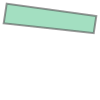

In [4]:
t = time()
lu_gdf = gpd.read_file(lu_path + 'lu_gtha.shp')
elapsed = time() - t

print("----- GeoDataFrame loaded"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(lu_gdf.shape[0], lu_gdf.shape[1]) + 
      "\n-- Column names:\n", lu_gdf.columns)

cols = ['PIN', 'LANDUSE', 'PROP_CODE', 'geometry']

print("Taking the subset with columns\n:", cols)

lu_gdf = lu_gdf[cols]

print("\n-- New column names:\n", lu_gdf.columns)
     
# lu_gta_gdf.plot(); # plotting the whole GeoDataFrame can take a very long time
lu_gdf.iloc[0].geometry

## Load Teranet data

In [5]:
t = time()
teranet_df = pd.read_csv(teranet_path + '1.3_Teranet_DA_TAZ_PG_FSA.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_df.shape[0], teranet_df.shape[1]) + 
      "\n-- Column names:\n", teranet_df.columns)

t = time()
# combine values in columns 'x' and 'y' into a POINT geometry object
geometry = [Point(xy) for xy in zip(teranet_df['X'], teranet_df['Y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
teranet_gdf = gpd.GeoDataFrame(teranet_df, geometry=geometry)
elapsed = time() - t
print("\n----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_gdf.shape[0], teranet_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_gdf.columns)

# add CRS for WGS84 (lat-long) to GeoDataFrame with Teranet records
teranet_gdf.crs = {'proj': 'latlong', 
                   'ellps': 'WGS84', 
                   'datum': 'WGS84', 
                   'no_defs': True}
print("\n----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!")

----- DataFrame loaded
in 27.39 seconds
with 6,803,691 rows
and 23 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O', 'FSA', 'PCA_ID', 'postal_code_dmti'],
      dtype='object')

----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!
in 94.88 seconds (1.58 minutes)
with 6,803,691 rows
and 24 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O', 'FSA', 'PCA_ID', 'postal_code_dmti', 'geometry'],
      dtype='object')

-----

## Perform the spatial join of Teranet points with DA polygons
### Validate projections

In [6]:
teranet_gdf.crs

{'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}

In [7]:
lu_gdf.crs

{'init': 'epsg:4326'}

### Perform the spatial join
>Note: EPSG:4326 and WGS 84 represent the [same projection](https://spatialreference.org/ref/epsg/wgs-84/).

In [8]:
t = time()
teranet_lu_gdf = gpd.sjoin(teranet_gdf, lu_gdf, 
                           how='left', op='within')
elapsed = time() - t
print("\n----- Spatial join completed, new GeoDataFrame created"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_lu_gdf.shape[0], teranet_lu_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_lu_gdf.columns)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')



----- Spatial join completed, new GeoDataFrame created
in 1173.59 seconds (19.56 minutes)
with 6,803,702 rows
and 28 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O', 'FSA', 'PCA_ID', 'postal_code_dmti', 'geometry',
       'index_right', 'PIN', 'LANDUSE', 'PROP_CODE'],
      dtype='object')


#### Rename column 'PIN' to 'pin_lu'

In [9]:
teranet_lu_gdf = teranet_lu_gdf.rename(columns={'PIN': 'pin_lu'})
print("Column was renamed.")

Column was renamed.


### Remove duplicated Teranet records generated by the spatial join
#### Examples of records duplicated by the spatial join

In [10]:
len(teranet_lu_gdf)

6803702

In [11]:
teranet_lu_gdf['transaction_id'].nunique()

6803691

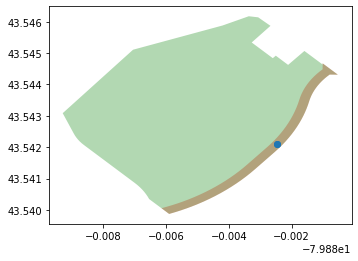

In [12]:
mask1 = lu_gdf['PIN'] == 249770111
ax = lu_gdf[mask1].plot(color='red', alpha=0.3)

mask1 = lu_gdf['PIN'] == 249770101
lu_gdf[mask1].plot(color='green', alpha=0.3, ax=ax);

mask1 = teranet_lu_gdf['transaction_id'] == 650458
teranet_lu_gdf[mask1].plot(ax=ax);

12 transactions


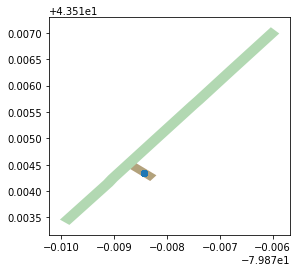

In [13]:
mask1 = lu_gdf['PIN'] == 249540053
ax = lu_gdf[mask1].plot(color='red', alpha=0.3)

mask1 = lu_gdf['PIN'] == 249540003
lu_gdf[mask1].plot(color='green', alpha=0.3, ax=ax);

mask1 = teranet_lu_gdf['transaction_id'].isin([1987359, 818179, 2437521, 2452046, 3338396, 3545450])
print(len(teranet_lu_gdf[mask1]), 'transactions')
teranet_lu_gdf[mask1].plot(ax=ax);

#### Correct the PINs of records duplicated by the spatial join
Values of `pin_lu` are replaced by the values of `pin` for Teranet records duplicated by the spatial join.

In [14]:
mask1 = teranet_lu_gdf.duplicated(subset='transaction_id', keep=False)
teranet_lu_gdf.loc[mask1, ['transaction_id', 'pin', 'pin_lu']]

,transaction_id,pin,pin_lu
650458,650458,249770111,249770111.0
650458,650458,249770111,249770101.0
818179,818179,249540053,249540053.0
818179,818179,249540053,249540003.0
1872698,1872698,249620306,249620306.0
1872698,1872698,249620306,249620464.0
1987359,1987359,249540053,249540053.0
1987359,1987359,249540053,249540003.0
2437521,2437521,249540053,249540053.0
2437521,2437521,249540053,249540003.0


In [15]:
teranet_lu_gdf.loc[mask1, 'pin_lu'] = teranet_lu_gdf.loc[mask1, 'pin']
print("{0:,} values were corrected.".format(len(teranet_lu_gdf[mask1])))

22 values were corrected.


#### Remove duplicate records from the GeoDataFrame

In [16]:
old_len = len(teranet_lu_gdf)
teranet_lu_gdf = teranet_lu_gdf.drop_duplicates(subset='transaction_id')
print("{0:,} records were dropped. {1:,} records remain in the GeoDataFrame."
      .format(old_len - len(teranet_lu_gdf), len(teranet_lu_gdf)))

11 records were dropped. 6,803,691 records remain in the GeoDataFrame.


### Save results to a .csv file

In [17]:
teranet_lu_gdf.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O', 'FSA', 'PCA_ID', 'postal_code_dmti', 'geometry',
       'index_right', 'pin_lu', 'LANDUSE', 'PROP_CODE'],
      dtype='object')

In [18]:
save_path = teranet_path + '1.4_Teranet_DA_TAZ_FSA_LU.csv'
t = time()
teranet_lu_gdf.drop(['index_right', 'geometry'], axis=1).to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60))

DataFrame saved to file:
 ../../data/teranet/1.4_Teranet_DA_TAZ_FSA_LU.csv 
took 180.74 seconds (3.01 minutes)
